In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import numpy as np
import torch
import torch.nn as nn
import os
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import pandas as pd

2025-04-19 16:40:28.452922: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-19 16:40:29.890094: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745095230.370413    5988 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745095230.494378    5988 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745095231.680473    5988 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
image_dir = '/scratch/ac9743/pytorch-example/tier1/images'
label_dir = '/scratch/ac9743/pytorch-example/tier1/labels'

In [3]:
df = pd.read_csv("/scratch/ac9743/pytorch-example/tier1.csv")

# For the GAN we only care about post disaster iamges and those that are damaged. 
filtered_df = df[
    (df["stage"] == "post") &
    (df["feature_type"] == "building") &
    (df["subtype"].isin(["major-damage", "destroyed"]))
]

In [4]:
print(filtered_df["disaster_type"].unique())
num_disaster_types = len(filtered_df["disaster_type"].unique())
print(num_disaster_types)

['hurricane' 'earthquake' 'flooding' 'tsunami' 'wildfire' 'fire']
6


## Converting Image Type so Compatible with PIL

In [5]:
import os
import json
import numpy as np
import tifffile
from PIL import Image, ImageDraw
from shapely import wkt
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, metadata_df, image_dir, label_dir, image_size=(64, 64)): 
        self.metadata_df = metadata_df
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.image_size = image_size

    def __len__(self):
        return len(self.metadata_df)

    def preprocess_image(self, image):
        # Resize and normalize image
        image = image.resize(self.image_size)
        image = np.array(image).astype(np.float32) / 255.0  # Normalize to [0, 1]
        return torch.from_numpy(image).permute(2, 0, 1)  # Convert to tensor and rearrange dims to [C, H, W]

    def preprocess_mask(self, mask):
        mask = mask.resize(self.image_size)
        mask = np.array(mask).astype(np.float32)
        return torch.from_numpy(mask).unsqueeze(0)  # Shape [1, H, W]

    def __getitem__(self, idx):
        row = self.metadata_df.iloc[idx]
        img_path = os.path.join(self.image_dir, row["image_filename"])
        label_path = os.path.join(self.label_dir, row["label_filename"])

        # Load image using tifffile
        image = tifffile.imread(img_path)
        if image.dtype == np.int16:
            image = np.clip(image, 0, 255).astype(np.uint8)
        image = Image.fromarray(image).convert("RGB")

        # Load mask from polygons
        mask = Image.new("L", self.image_size, 0)
        draw = ImageDraw.Draw(mask)

        with open(label_path, 'r') as f:
            label_data = json.load(f)

        features = label_data.get("features", {}).get("lng_lat", [])
        for feature in features:
            wkt_str = feature.get("wkt")
            try:
                poly = wkt.loads(wkt_str)
                if poly.is_valid:
                    coords = [(x, y) for x, y in poly.exterior.coords]
                    draw.polygon(coords, outline=1, fill=1)
            except Exception as e:
                print(f"Polygon error in {label_path}: {e}")

        # Preprocess image and mask
        image_tensor = self.preprocess_image(image)
        mask_tensor = self.preprocess_mask(mask)

        return {
            "image": image_tensor,        # shape: [3, 64, 64]
            "mask": mask_tensor,          # shape: [1, 64, 64]
            "stage": row["stage"],
            "disaster_type": row["disaster_type"]
        }

# GAN - From lab 8

In [6]:
dataset = CustomDataset(filtered_df, image_dir, label_dir)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [7]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)

/home/ac9743/.local/lib/python3.9/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
2025-04-19 16:41:10.860808: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [8]:
discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 404,801 (1.54 MB)

 Trainable params: 404,801 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)

In [10]:
generator.summary()


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 8192)           │     1,056,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 256)    │       524,544 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 512)    │     2,097,664 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 64, 64, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 3)      │        38,403 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,979,651 (15.18 MB)

 Trainable params: 3,979,651 (15.18 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim))
        generated_images = self.generator(random_latent_vectors)
        combined_images = tf.concat([generated_images, real_images], axis=0)
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))],
            axis=0
        )

        # Add noise to discriminator labels to make it's job harder
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim))

        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(
                self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(
            zip(grads, self.generator.trainable_weights))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(),
                "g_loss": self.g_loss_metric.result()}

In [12]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        
        # If the output is in [-1, 1], scale to [0, 255]
        generated_images = (generated_images + 1) * 127.5

        # Create a directory to store generated images if it doesn't exist
        os.makedirs("generated_images", exist_ok=True)

        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save(f"generated_images/generated_img_{epoch:03d}_{i}.png")

In [13]:
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

In [26]:
epochs = 40
batch_size = 32

# Converting to a tensor dataframe because GAN model is in tensor/keras

def preprocess_image_tf(item):
    return tf.convert_to_tensor(item["image"], dtype=tf.float32)

tf_dataset = tf.data.Dataset.from_generator(
    lambda: ({"image": tf.transpose(d["image"], (1, 2, 0))} for d in dataset),
    output_signature={
        "image": tf.TensorSpec(shape=(64, 64, 3), dtype=tf.float32),
    }
)

tf_dataset = tf_dataset.map(lambda x: x["image"]).batch(batch_size)
tf_dataset = tf_dataset.repeat()

In [27]:
_ = generator(tf.random.normal((1, latent_dim)))
_ = discriminator(tf.random.normal((1, 64, 64, 3)))

In [28]:
# Set steps per epoch based on the batch size
steps_per_epoch = len(dataset) // batch_size 

# Train the GAN
gan.fit(
    tf_dataset,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Epoch 1/40
215/215 ━━━━━━━━━━━━━━━━━━━━ 245s 1s/step - d_loss: 0.6429 - g_loss: 0.9699
Epoch 2/40
215/215 ━━━━━━━━━━━━━━━━━━━━ 249s 1s/step - d_loss: 0.7023 - g_loss: 0.6394
Epoch 3/40
215/215 ━━━━━━━━━━━━━━━━━━━━ 228s 1s/step - d_loss: 0.6805 - g_loss: 0.7838
Epoch 4/40
215/215 ━━━━━━━━━━━━━━━━━━━━ 238s 1s/step - d_loss: 0.6568 - g_loss: 0.8035
Epoch 5/40
215/215 ━━━━━━━━━━━━━━━━━━━━ 221s 1s/step - d_loss: 0.6886 - g_loss: 0.9215
Epoch 6/40
215/215 ━━━━━━━━━━━━━━━━━━━━ 228s 1s/step - d_loss: 0.7372 - g_loss: 0.9149
Epoch 7/40
215/215 ━━━━━━━━━━━━━━━━━━━━ 229s 1s/step - d_loss: 0.6612 - g_loss: 0.7857
Epoch 8/40
215/215 ━━━━━━━━━━━━━━━━━━━━ 214s 998ms/step - d_loss: 0.6643 - g_loss: 0.7830
Epoch 9/40
215/215 ━━━━━━━━━━━━━━━━━━━━ 222s 1s/step - d_loss: 0.6859 - g_loss: 0.8421
Epoch 10/40
215/215 ━━━━━━━━━━━━━━━━━━━━ 228s 1s/step - d_loss: 0.6995 - g_loss: 0.9441
Epoch 11/40
215/215 ━━━━━━━━━━━━━━━━━━━━ 231s 1s/step - d_loss: 0.6775 - g_loss: 0.9864
Epoch 12/40
215/215 ━━━━━━━━━━━━━━━━━━

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



215/215 ━━━━━━━━━━━━━━━━━━━━ 246s 1s/step - d_loss: 0.6664 - g_loss: 0.8053
Epoch 36/40
215/215 ━━━━━━━━━━━━━━━━━━━━ 242s 1s/step - d_loss: 0.7291 - g_loss: 0.8874
Epoch 38/40
215/215 ━━━━━━━━━━━━━━━━━━━━ 244s 1s/step - d_loss: 0.6965 - g_loss: 0.8052
Epoch 39/40
215/215 ━━━━━━━━━━━━━━━━━━━━ 242s 1s/step - d_loss: 0.6517 - g_loss: 0.7919
Epoch 40/40
215/215 ━━━━━━━━━━━━━━━━━━━━ 246s 1s/step - d_loss: 0.6661 - g_loss: 0.8340


In [43]:
def read_imgs():
    img_arr = []
    for i in range(40):
      for j in range(10):
        img = Image.open('/scratch/ac9743/pytorch-example/generated_images/generated_img_' + '{:03}'.format(i)+'_'+str(j)+'.png').convert('RGB')
        img = np.asarray(img)
        img_arr.append(img)
    return img_arr

In [44]:
imgs = read_imgs()
print(len(imgs))

400


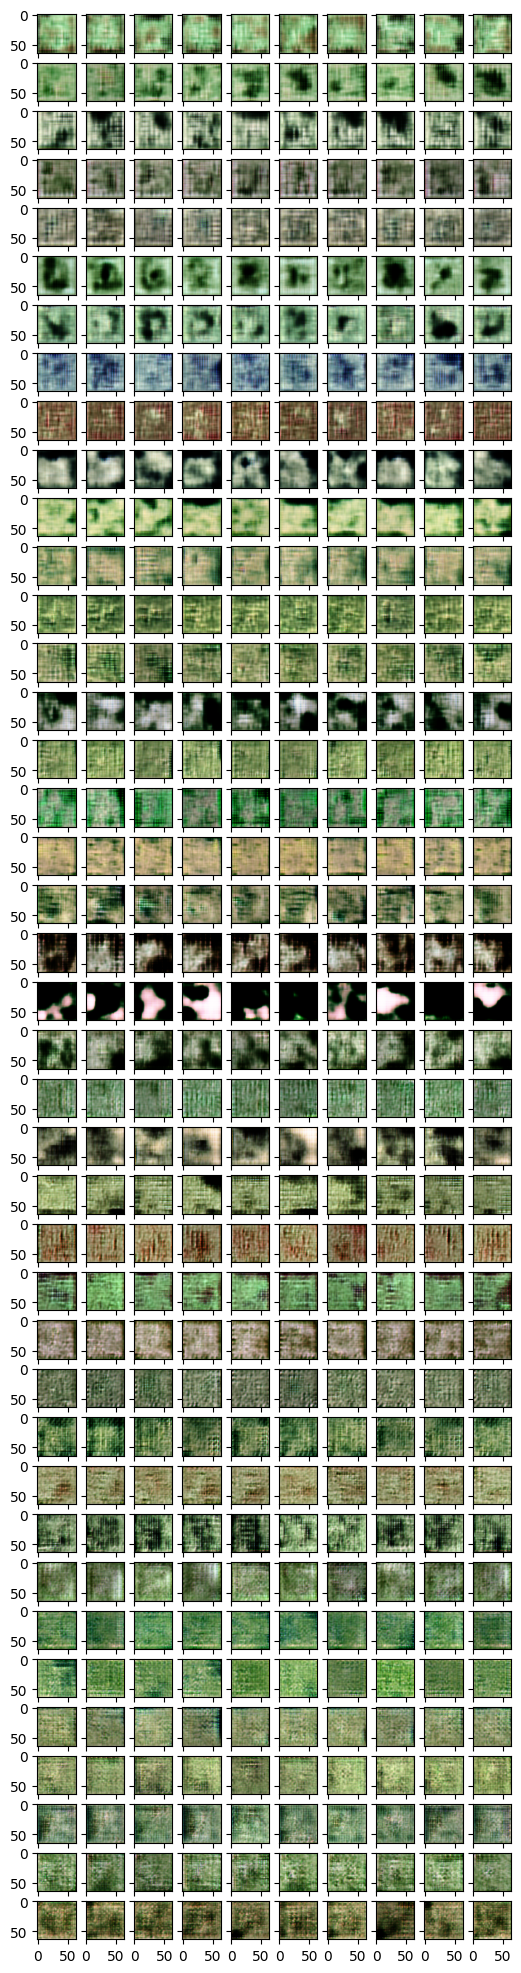

In [46]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(100., 25.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(40, 10),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes
                 )

for ax, im in zip(grid, imgs):
    ax.imshow(im)

plt.show()